In [512]:
import pandas_datareader as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 



In [513]:
# datetime . datetime is a data type within the datetime module
start = datetime . datetime (2020 , 1 , 1)
end = datetime . datetime (2021 , 1 , 1)


In [514]:
# DataReader method name is case sensitive
tsla = web . DataReader ("tsla", 'yahoo', start , end )


# Exploratory Data Analysis

In [515]:
tsla.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,84.258003,80.416000,81.000000,83.666000,51428500.0,83.666000
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996


In [516]:
tsla.shape

(254, 6)

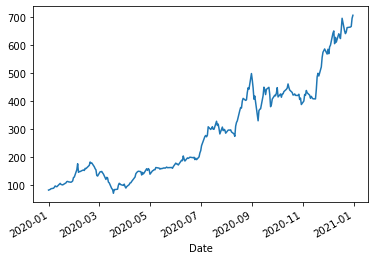

In [518]:
tsla_close = tsla['Close']
tsla_close.plot()
plt.show()

# Trading Strategy Using Simple Moving Average Crossover

In [519]:
tsla['MA30'] = tsla['Close'].rolling(30).mean()
tsla['MA10']= tsla['Close'].rolling(10).mean()

<AxesSubplot:xlabel='Date'>

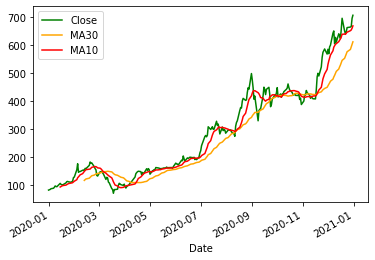

In [520]:
tsla['Close'].plot(legend = True, color = "green")
tsla['MA30'].plot(legend = True, color = "orange")
tsla['MA10'].plot(legend = True, color = "red")

In [521]:
#buy when MA 10 is above MA 30
tsla['shares'] = [1 if tsla.loc[i, 'MA10']> tsla.loc[i,'MA30'] else 0 for i in tsla.index]

In [522]:
tsla['Y'] = tsla['Close'].shift(-1)- tsla['Close']
tsla['Profit'] = [tsla.loc[i, 'Y'] if tsla.loc[i, 'shares'] == 1 else 0 for i in tsla.index]

<AxesSubplot:xlabel='Date'>

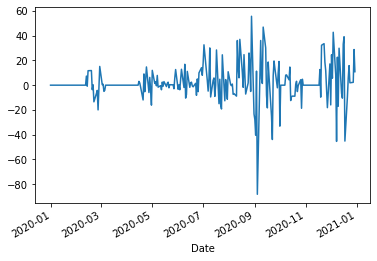

In [523]:
tsla['Profit'].plot()

<AxesSubplot:xlabel='Date'>

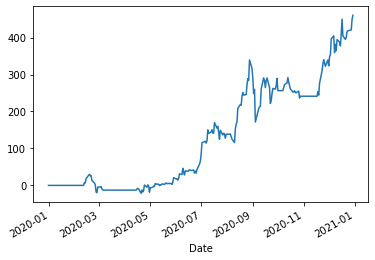

In [524]:
tsla['Profit'].cumsum().plot()

# Linear Regression Model 

In [550]:
#feature engineering
tsla['X1']= tsla['Close']-tsla['Close'].shift (1)
tsla['X2']= tsla['High']-tsla['Low']
tsla['X3']= tsla['High']-tsla['Close']
tsla['X4']=tsla['Volume']-tsla['Volume'].shift (1)
tsla['X5']=tsla['Adj Close']-tsla['Open']
tsla['X6']=tsla['Open']-tsla['High']
tsla['X7']=tsla['Open']-tsla['Low']
tsla['X8']=tsla['Adj Close']-tsla['Adj Close'].shift(1)

tsla = tsla.dropna(axis=0)

feature=['Y','X1','X2','X3','X4','X5','X6','X7','X8']
tsla[feature].corr()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
Y,1.000000,-0.045734,-0.112917,0.036505,-0.116734,-0.053244,0.040441,-0.105226,-0.045734
X1,-0.045734,1.000000,0.109420,-0.558306,0.247723,0.747121,-0.527210,-0.347759,1.000000
X2,-0.112917,0.109420,1.000000,0.538100,0.336882,0.110120,-0.619864,0.690708,0.109420
X3,0.036505,-0.558306,0.538100,1.000000,0.116492,-0.677871,0.047126,0.722474,-0.558306
X4,-0.116734,0.247723,0.336882,0.116492,1.000000,0.150095,-0.305735,0.143378,0.247723
X5,-0.053244,0.747121,0.110120,-0.677871,0.150095,1.000000,-0.766310,-0.567213,0.747121
X6,0.040441,-0.527210,-0.619864,0.047126,-0.305735,-0.766310,1.000000,0.139304,-0.527210
X7,-0.105226,-0.347759,0.690708,0.722474,0.143378,-0.567213,0.139304,1.000000,-0.347759
X8,-0.045734,1.000000,0.109420,-0.558306,0.247723,0.747121,-0.527210,-0.347759,1.000000


In [531]:
#train, test split
train = tsla.iloc[:180,:]
test = tsla.iloc[180:,:]

In [565]:
#select the 3 best predictors
import statsmodels.formula.api as smf
trainmodel = smf.ols(formula='Y ~ X2+X4+X7', data=train).fit()
train['Y_predict']=trainmodel.predict(train)
test['Y_predict']=trainmodel.predict(test)

In [566]:
train['Profit']=[train.loc[t,'Y'] if train.loc[t,'Y_predict']>0 else 0 for t in train.index]
test['Profit']=[test.loc[t,'Y'] if test.loc[t,'Y_predict']>0 else 0 for t in test.index]

In [567]:
train['Profit'].mean(),test['Profit'].mean()

(1.5541001213921442, 2.837954434481534)

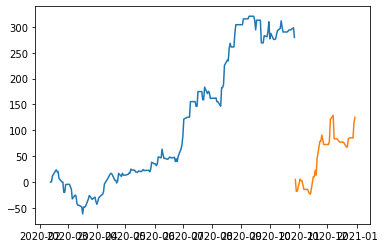

In [554]:
plt.plot(train['Profit'].cumsum())
plt.plot(test['Profit'].cumsum())

# Model Evaluation

In [555]:
def RMSE(data,k):
    return ((((data['Y']-data['Y_predict'])**2).sum())/(data.shape[0]-k-1))**0.5
def R2(data,model_k):
    SST=((data['Y']-data['Y'].mean())**2).sum()
    SSE=((data['Y']-data['Y_predict'])**2).sum()
    SSR=((data['Y'].mean()-data['Y_predict'])**2).sum()
    r2=SSR/SST
    return 1-(1-r2)*(data.shape[0]-1)/(data.shape[0]-model_k-1)

In [556]:
rmse_train = RMSE(train,8)
rmse_test = RMSE(test,8)

In [557]:
#consistency of the model
r2_train= R2(train,8)
r2_test = R2(test,8)

In [558]:
assessment = pd.DataFrame(index= ['R2', 'RMSE']
                         ,columns = ['Train', 'Test'])
assessment['Train']= [r2_train, rmse_train]
assessment ['Test'] = [r2_test, rmse_test]
assessment

,Train,Test
R2,0.011641,0.009129
RMSE,15.135023,25.383008


# Trade using Signals

In [568]:
Trade_Test=pd.DataFrame()
Trade_Test['Price']=test['Close']
Trade_Test['Signal']=test['Y_predict']
Trade_Test.head()

,Price,Signal
Date,,
2020-10-28,406.019989,0.571653
2020-10-29,410.829987,2.972221
2020-10-30,388.040009,-6.045743
2020-11-02,400.510010,3.966693
2020-11-03,423.899994,2.327809


In [569]:
#buy when there is a profit predicted, sell when negative profit is predicted
Trade_Test['Order']=[1 if sig>0 else -1 for sig in Trade_Test['Signal']  ]
Trade_Test['Price_change']=Trade_Test['Price']-Trade_Test['Price'].shift(1)
Trade_Test['Profit']=Trade_Test['Price_change']*Trade_Test['Order']
print(Trade_Test['Profit'].sum())
Trade_Test['Wealth']=Trade_Test['Profit'].cumsum()+Trade_Test['Price'][0]
Trade_Test.head()

263.7799987792969


,Price,Signal,Order,Price_change,Profit,Wealth
Date,,,,,,
2020-10-28,406.019989,0.571653,1,NaN,NaN,NaN
2020-10-29,410.829987,2.972221,1,4.809998,4.809998,410.829987
2020-10-30,388.040009,-6.045743,-1,-22.789978,22.789978,433.619965
2020-11-02,400.510010,3.966693,1,12.470001,12.470001,446.089966
2020-11-03,423.899994,2.327809,1,23.389984,23.389984,469.479950


<AxesSubplot:xlabel='Date'>

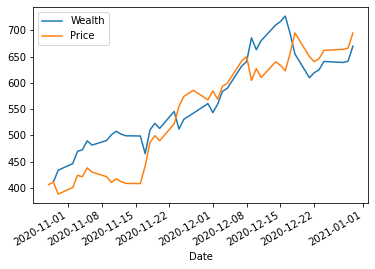

In [570]:
Trade_Test['Wealth'].plot(legend = True)
Trade_Test['Price'].plot(legend = True)

# Performance: Sharpe Ratio and Maximum Drawdown

In [571]:
Trade_Test.head()
# daily return
Trade_Test['Return']=(Trade_Test['Wealth']
                      -Trade_Test['Wealth'].shift(1))/Trade_Test['Wealth'].shift(1)
dailyr=Trade_Test['Return'].dropna()
print("daily sharpe ratio is ", dailyr.mean()/dailyr.std(ddof=1))
print("yearly sharpe ratio is", (220**0.5)*dailyr.mean()/dailyr.std(ddof=1))

daily sharpe ratio is  0.325312602819219
yearly sharpe ratio is 4.825165665722088


In [572]:
Trade_Test['Peak']=[Trade_Test['Wealth'].loc[:any_index].max() 
                    for any_index in Trade_Test.index ]
Trade_Test['Drawdown']=(Trade_Test['Peak']-Trade_Test['Wealth'])/Trade_Test['Peak']
print("Maximum drawdown rate in test is", Trade_Test['Drawdown'].max())

Maximum drawdown rate in test is 0.16143318490861347


# 